## Excercise 4 - **Introduction to distributed parallelization**

The goal of this exercise is to:
- understand the basic idea of distributed parallelization;
- and learn about MPI.jl on the way.

[*This content is distributed under MIT licence. Authors: S. Omlin (CSCS), L. Räss (ETHZ).*](https://github.com/eth-vaw-glaciology/course-101-0250-00/blob/main/LICENSE.md)

*Note: this course material is to a large part reusing material created by Ludovic Räss, ETH Zurich.*

In this part notebook, we will explore distributed computing with Julia's MPI wrapper MPI.jl. This will enable our codes to run on multiple CPUs and GPUs in order to scale on modern multi-CPU/GPU nodes, clusters and supercomputers. In the proposed approach, each MPI process handles one CPU or GPU.

As a first step, we will look at the below 1-D diffusion code which solves the linear diffusion equations using a "fake-parallelisation" approach. We split the calculation on two distinct left and right domains, which requires left and right `H` arrays, `HL` and `HR`, respectively. In this "fake parallelization" code, the computations for the left and right domain are performed sequentially on one process, but they could be computed on two distinct processes if the needed boundary update (often referred to as halo update in literature) was done with MPI. The idea of this fake parallelization approach is the following:
```julia
# Compute physics locally
HL[2:end-1] .= HL[2:end-1] .+ dt*λ*diff(diff(HL)/dx)/dx
HR[2:end-1] .= HR[2:end-1] .+ dt*λ*diff(diff(HR)/dx)/dx
# Update boundaries (later MPI)
HL[end] = ...
HR[1]   = ...
# Global picture
H .= [HL[1:end-1]; HR[2:end]]
```
We see that a correct boundary update will be the critical part for a successful implementation. In our approach, we need an overlap of 2 cells between `HL` and `HR` in order to avoid any wrong computations at the transition between the left and right domains.

### Task 1 (fake parallelization with 2 fake processes)

Run the below "fake parallelization" 1-D diffusion code which is missing the boundary updates of the 2 fake processes and describe what you see in the visualization. Then, add the required boundary update in order make the code work properly and run it again. Note what has changed in the visualization.

In [1]:
# ] activate .

In [2]:
# ] instantiate

In [3]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/github/Learning/Courses/AdvancedCUDA/part2/solutions`


In [ ]:
# solution
# Linear 1D diffusion with 2 fake mpi processes
using Plots

# enable plotting by default
if !@isdefined do_visu; do_visu = true end

@views function diffusion_1D_2procs(; do_visu=true)
    # Physics
    Hl  = 10.0   # left  H
    Hr  = 1.0    # right H
    λ   = 1.0    # diffusion coeff
    nt  = 200    # number of time steps
    # Numerics
    nx  = 32     # number of local grid points
    dx  = 1.0    # cell size
    # Derived numerics
    dt  = dx^2/λ/2.1
    # Initial condition
    HL  = Hl*ones(nx)
    HR  = Hr*ones(nx)
    H   = [HL[1:end-1]; HR[2:end]]
    Hg  = copy(H)
    # Time loop
    @gif for it = 1:nt
        # Compute physics locally
        HL[2:end-1] .= HL[2:end-1] .+ dt*λ*diff(diff(HL)/dx)/dx
        HR[2:end-1] .= HR[2:end-1] .+ dt*λ*diff(diff(HR)/dx)/dx
        # Update boundaries
        HL[end] = HR[2]
        HR[1]   = HL[end-1]
        # Global picture
        H .= [HL[1:end-1]; HR[2:end]]
        # Compute physics globally (check)
        Hg[2:end-1] .= Hg[2:end-1] .+ dt*λ*diff(diff(Hg)/dx)/dx
        # Visualise
        if do_visu
            fontsize = 12
            plot(Hg, legend=false, linewidth=0, markershape=:circle, markersize=5, yaxis=font(fontsize, "Courier"), xaxis=font(fontsize, "Courier"), titlefontsize=fontsize, titlefont="Courier")
            plot!(H, legend=false, linewidth=3, framestyle=:box, xlabel="Lx", ylabel="H", title="diffusion (it=$(it))")
        end
    end
    return
end

diffusion_1D_2procs(; do_visu=do_visu)
# see `diffusion_1D_2procs.gif``

┌ Info: Saved animation to /tmp/jl_vy7W3aHohc.gif
└ @ Plots /home/araki/.julia/packages/Plots/Ec1L1/src/animation.jl:156


The next step will be to generalise the fake parallelization with `2` fake processes to work with `n` fake processes. The idea of this generalized fake parallelization approach is the following:
```julia
for ip = 1:np    # compute physics locally
    H[2:end-1,ip] .= H[2:end-1,ip] .+ dt*λ*diff(diff(H[:,ip])/dxg)/dxg
end
for ip = 1:np-1  # update boundaries
    ...
end
for ip = 1:np    # global picture
    i1 = 1 + (ip-1)*(nx-2)
    Hg[i1:i1+nx-2] .= H[1:end-1,ip]
end
```
The array `H` contains now `n` local domains where each domain belongs to one fake process, namely the fake process indicated by the second index of `H` (ip). The boundary updates are to be adapted accordingly. All the physical calculations happen on the local chunks of the arrays. We only need "global" knowledge in the definition of the initial condition, in order to e.g. initialise the step function used in the previous code.

### Task 2 (fake parallelization with n fake processes)

Modify the initial condition in the below "fake parallelization" 1-D diffusion code with `n` fake processes to match the initial condition of the previous code (a step function). Then run this code which is missing the boundary updates of the `n` fake processes and describe what you see in the visualization. Then, add the required boundary update in order make the code work properly and run it again. Note what has changed in the visualization.

┌ Info: Saved animation to /tmp/jl_lItGnOZ2pm.gif
└ @ Plots /home/araki/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_lItGnOZ2pm.gif")
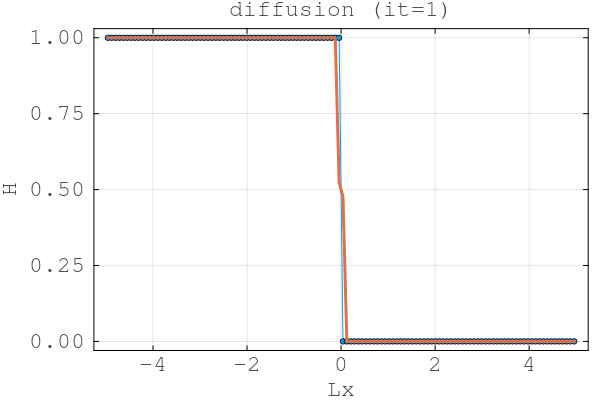

In [ ]:
# solution
# Linear 1D diffusion with n fake mpi processes
using Plots

# enable plotting by default
if !@isdefined do_visu; do_visu = true end

@views function diffusion_1D_nprocs(; do_visu=true)
    # Physics
    lx  = 10.0
    λ   = 1.0
    nt  = 200
    # Numerics
    np  = 4             # number of procs
    nx  = 32            # local number of grid points
    # Derived numerics
    nxg = (nx-2)*np+2   # global number of grid points
    dxg = lx/nxg        # dx for global grid
    dt  = dxg^2/λ/2.1
    # Array allocation
    x   = zeros(nx,np)  # local coord array
    H   = zeros(nx,np)  # local H array
    xt  = zeros(nxg)    # global coord array
    Ht  = zeros(nxg)    # global initial H array
    Hg  = zeros(nxg)    # global H array
    # Initial condition
    for ip = 1:np
        i1 = 1 + (ip - 1) * (nx - 2)
        for ix = 1:nx
            x[ix, ip] = ((ip - 1) * (nx - 2) + (ix - 0.5)) * dxg - 0.5 * lx
            if x[ix,ip] <= 0.0
                H[ix, ip] = 1.0
            else
                H[ix, ip] = 0.0
            end
        end
        xt[i1:i1+nx-2] .= x[1:end-1, ip]
        if (ip == np)
            xt[i1+nx-1] = x[end, ip]
        end
        Ht[i1:i1+nx-2] .= H[1:end-1, ip]
        if (ip == np)
            Ht[i1+nx-1] = H[end, ip]
        end
    end
    # Time loop
    @gif for it = 1:nt
        # Compute physics locally
        for ip = 1:np
            H[2:end-1,ip] .= H[2:end-1,ip] .+ dt*λ*diff(diff(H[:,ip])/dxg)/dxg
        end
        # Update boundaries
        for ip = 1:np-1
            H[end,ip  ] = H[    2,ip+1]
            H[  1,ip+1] = H[end-1,ip  ]
        end
        # Global picture
        for ip = 1:np
            i1 = 1 + (ip-1)*(nx-2)
            Hg[i1:i1+nx-2] .= H[1:end-1,ip]
        end
        # Visualise
        if do_visu
            fontsize = 12
            plot(xt, Ht, legend=false, linewidth=1, markershape=:circle, markersize=3, yaxis=font(fontsize, "Courier"), xaxis=font(fontsize, "Courier"), titlefontsize=fontsize, titlefont="Courier")
            plot!(xt, Hg, legend=false, linewidth=3, framestyle=:box, xlabel="Lx", ylabel="H", title="diffusion (it=$(it))")
        end
    end
end

diffusion_1D_nprocs(; do_visu=do_visu)
# see `diffusion_1D_nprocs.gif`

The previous simple initial conditions can be easily defined without computing any Carthesian coordinates. To define other initial conditions we often need to compute global coordinates. In the code below, which serves to define a Gaussian anomaly in the center of the domain, they can be computed for each cell based on the process id (`ip`), the cell id (`ix`), the array size (`nx`), the overlap of the local domains (`2`) and the grid spacing of the global grid (`dxg`); moreover, the origin of the coordinate system can be moved to any position using the global domain length (`lx`):
```julia
# Initial condition
for ip = 1:np
    for ix = 1:nx
        x[ix,ip] = ...
        H[ix,ip] = exp(-x[ix,ip]^2)
    end
    i1 = 1 + (ip-1)*(nx-2)
    xt[i1:i1+nx-2] .= x[1:end-1,ip]; if (ip==np) xt[i1+nx-1] = x[end,ip] end
    Ht[i1:i1+nx-2] .= H[1:end-1,ip]; if (ip==np) Ht[i1+nx-1] = H[end,ip] end
end
```

### Task 3 (fake parallelization with n fake processes)

Modify the initial condition in the below code (which is the same as above) to a centered Gaussian anomaly. Then run this code which is missing the boundary updates of the `n` fake processes and describe what you see in the visualization. Then, add the required boundary update in order make the code work properly and run it again. Note what has changed in the visualization.

┌ Info: Saved animation to /tmp/jl_vYvk1KLu7Y.gif
└ @ Plots /home/araki/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_vYvk1KLu7Y.gif")
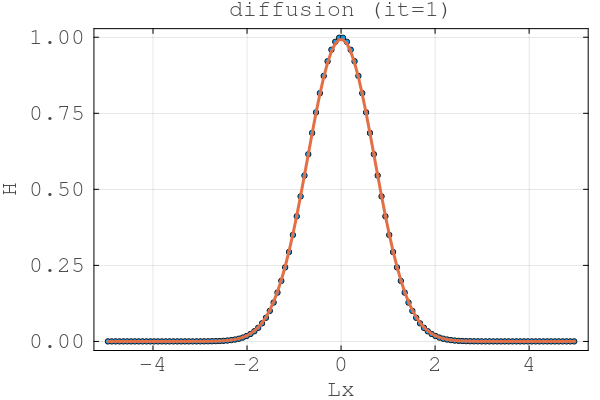

In [ ]:
# solution
# Linear 1D diffusion with n fake mpi processes
using Plots

# enable plotting by default
if !@isdefined do_visu; do_visu = true end

@views function diffusion_1D_nprocs(; do_visu=true)
    # Physics
    lx  = 10.0
    λ   = 1.0
    nt  = 200
    # Numerics
    np  = 4             # number of procs
    nx  = 32            # local number of grid points
    # Derived numerics
    nxg = (nx-2)*np+2   # global number of grid points
    dxg = lx/nxg        # dx for global grid
    dt  = dxg^2/λ/2.1
    # Array allocation
    x   = zeros(nx,np)  # local coord array
    H   = zeros(nx,np)  # local H array
    xt  = zeros(nxg)    # global coord array
    Ht  = zeros(nxg)    # global initial H array
    Hg  = zeros(nxg)    # global H array
    # Initial condition
    for ip = 1:np
        i1 = 1 + (ip-1)*(nx-2)
        for ix = 1:nx
            x[ix,ip] = ( (ip-1)*(nx-2) + (ix-0.5) )*dxg - 0.5*lx
            H[ix,ip] = exp(-x[ix,ip]^2)
        end
        xt[i1:i1+nx-2] .= x[1:end-1,ip]; if (ip==np) xt[i1+nx-1] = x[end,ip] end
        Ht[i1:i1+nx-2] .= H[1:end-1,ip]; if (ip==np) Ht[i1+nx-1] = H[end,ip] end
    end
    # Time loop
    @gif for it = 1:nt
        # Compute physics locally
        for ip = 1:np
            H[2:end-1,ip] .= H[2:end-1,ip] .+ dt*λ*diff(diff(H[:,ip])/dxg)/dxg
        end
        # Update boundaries
        for ip = 1:np-1
            H[end,ip  ] = H[    2,ip+1]
            H[  1,ip+1] = H[end-1,ip  ]
        end
        # Global picture
        for ip = 1:np
            i1 = 1 + (ip-1)*(nx-2)
            Hg[i1:i1+nx-2] .= H[1:end-1,ip]
        end
        # Visualise
        if do_visu
            fontsize = 12
            plot(xt, Ht, legend=false, linewidth=1, markershape=:circle, markersize=3, yaxis=font(fontsize, "Courier"), xaxis=font(fontsize, "Courier"), titlefontsize=fontsize, titlefont="Courier")
            plot!(xt, Hg, legend=false, linewidth=3, framestyle=:box, xlabel="Lx", ylabel="H", title="diffusion (it=$(it))")
        end
    end
end

diffusion_1D_nprocs(; do_visu=do_visu)
# see `diffusion_1D_nprocs_exp.gif`

We are now ready to write a code that will truly distribute calculations on different processors using MPI.jl.
Let us see what are the somewhat minimal requirements that will allow us to write a distributed code in Julia using MPI.jl. We will solve the following linear diffusion physics:
```julia
for it = 1:nt
    qHx        .= .-λ*diff(H)/dx
    H[2:end-1] .= H[2:end-1] .- dt*diff(qHx)/dx
end
```
To enable distributed parallelization, we will do the following steps:
1. Initialise MPI and set up a Cartesian communicator
2. Implement a boundary exchange routine
3. Create a "global" initial condition
4. Finalise MPI

To (1.) initialise MPI and prepare the Cartesian communicator, we do:
````julia
MPI.Init()
dims        = [0]
comm        = MPI.COMM_WORLD
nprocs      = MPI.Comm_size(comm)
MPI.Dims_create!(nprocs, dims)
comm_cart   = MPI.Cart_create(comm, dims, [0], 1)
me          = MPI.Comm_rank(comm_cart)
coords      = MPI.Cart_coords(comm_cart)
neighbors_x = MPI.Cart_shift(comm_cart, 0, 1)
````
where `me` represents the process ID unique to each MPI process (the analogue to `ip` in the fake parallelization).

Then, we need to (2.) implement a boundary update routine, which can have the following structure:
```julia
@views function update_halo(A, neighbors_x, comm)
    # Send to / receive from neighbor 1 ("left neighbor")
    if neighbors_x[1] != MPI.MPI_PROC_NULL
        # ...
    end
    # Send to / receive from neighbor 2 ("right neighbor")
    if neighbors_x[2] != MPI.MPI_PROC_NULL
        # ...
    end
    return
end
```

Then, we (3.) initialize `H` with a "global" initial Gaussian anomaly that spans correctly over all local domains. This can be achieved, e.g., as given here:
```julia
x0    = coords[1]*(nx-2)*dx
xc    = [x0 + ix*dx - dx/2 - 0.5*lx  for ix=1:nx]
H     = exp.(.-xc.^2)
```
where `x0` represents the first global x-coordinate on every process (computed in function of `coords`) and `xc` represents the local chunk of the global coordinates on each local process (this is analogue to the initialization in the fake parallelization).

Last, we need to (4.) finalise MPI prior to returning from the main function:
```julia
MPI.Finalize()
```
All the above described is found in the code `diffusion_1D_mpi.jl`, except for the boundary updates (see 2.).

### Task 4 (1-D parallelization with MPI)

Run the code `diffusion_1D_mpi.jl` which is still missing the boundary updates three times: with 1, 2 and 4 processes; visualize the results after each run with the code that follows (adapt the variable nprocs!). Describe what you see in the visualization. Then, add the required boundary update in order make the code work properly and run it again. Note what has changed in the visualization.
> 💡 Hint: for the boundary updates, you can use the following approach for the communication with each neighbor: 1) create a sendbuffer and receive buffer, storing the right value in the send buffer; 2) use `MPI.Send` and `MPI.Recv!` to send/reveive the data; 3) store the received data in the right position in the Array.


メモ：`mpich`と`MPI.jl`をインストールすれば実行できる

```bash
$ sudo apt update
$ sudo apt install mpich
$ julia
julia> ]
(@v1.11) Pkg> add MPI
(@v1.11) Pkg> [backspace]
julia> using MPI
julia> MPI.install_mpiexecjl()
julia> exit()
$ mpiexecjl -n 2 julia diffusion_1D_mpi.jl
```

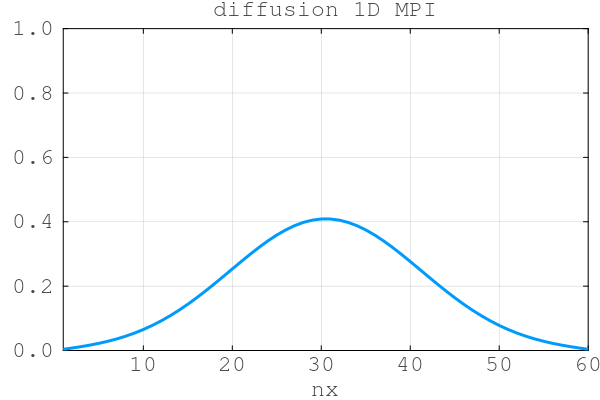

In [10]:
# solution
# Visualisation script for the 1D MPI solver
using Plots, MAT

nprocs = 2

@views function vizme1D_mpi(nprocs)
    H = []
    for ip = 1:nprocs
        file = matopen("H_$(ip-1).mat"); H_loc = read(file, "H"); close(file)
        nx_i = length(H_loc)-2
        i1   = 1 + (ip-1)*nx_i
        if (ip==1)  H = zeros(nprocs*nx_i)  end
        H[i1:i1+nx_i-1] .= H_loc[2:end-1]
    end
    fontsize = 12
    display(plot(H, legend=false, framestyle=:box, linewidth=3, xlims=(1, length(H)), ylims=(0, 1), xlabel="nx", title="diffusion 1D MPI", yaxis=font(fontsize, "Courier"), xaxis=font(fontsize, "Courier"), titlefontsize=fontsize, titlefont="Courier"))
    return
end

vizme1D_mpi(nprocs)

Congratulations! You just did a distributed diffusion solver in only 70 lines of code.
Let us now do the same in 2-D: there is not much new there, but it may be interesting to work out how boundary update routines can be defined in 2D as one now needs to exchange vectors instead of single values.

### Task 5 (2-D parallelization with MPI)

Run the code `diffusion_2D_mpi.jl` which is still missing the boundary updates three times: with 1, 2 and 4 processes; visualize the results after each run with the code that follows (adapt the variable nprocs!). Describe what you see in the visualization. Then, add the required boundary update in order make the code work properly and run it again. Note what has changed in the visualization.
> 💡 Hint: for the boudnary updates, you can use the following approach for the communication with each neighbor: 1) create a sendbuffer and receive buffer, storing the right value in the send buffer; 2) use `MPI.Send` and `MPI.Recv!` to send/reveive the data; 3) store the received data in the right position in the Array.

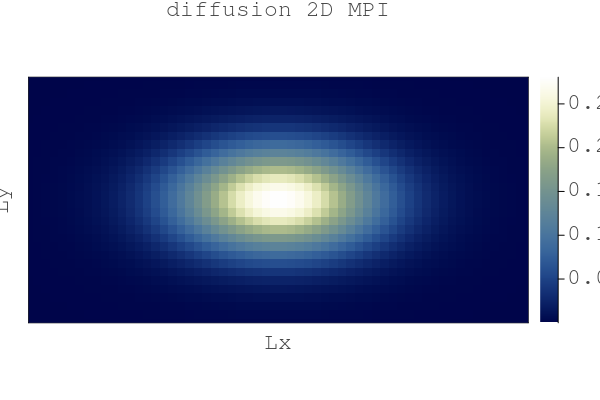

In [12]:
# solution
# Visualisation script for the 2D MPI solver
using Plots, MAT

nprocs = (2, 1) # nprocs (x, y) dim

@views function vizme2D_mpi(nprocs)
    H  = []
    ip = 1
    for ipx = 1:nprocs[1]
        for ipy = 1:nprocs[2]
            file = matopen("H_$(ip-1).mat"); H_loc = read(file, "H"); close(file)
            nx_i, ny_i = size(H_loc,1)-2, size(H_loc,2)-2
            ix1, iy1   = 1+(ipx-1)*nx_i, 1+(ipy-1)*ny_i
            if (ip==1)  H = zeros(nprocs[1]*nx_i, nprocs[2]*ny_i)  end
            H[ix1:ix1+nx_i-1,iy1:iy1+ny_i-1] .= H_loc[2:end-1,2:end-1]
            ip += 1
        end
    end
    fontsize = 12
    opts = (aspect_ratio=1, yaxis=font(fontsize, "Courier"), xaxis=font(fontsize, "Courier"),
        ticks=nothing, framestyle=:box, titlefontsize=fontsize, titlefont="Courier",
        xlabel="Lx", ylabel="Ly", xlims=(1, size(H,1)), ylims=(1, size(H,2)) )
    display(heatmap(H'; c=:davos, title="diffusion 2D MPI", opts...))
    return
end

vizme2D_mpi(nprocs)

Note that an HPC application will normally use non-blocking communication. That means that instead of `MPI.Send` and `MPI.Recv!` one can use `MPI.Isend` and `MPI.Irecv!` to asynchronously launch the communication and wait then at the end of the boundary updates with `MPI.Wait!` or `MPI.Waitall!` for completion of the communication. Note also, that in an HPC application, the receiving calls should be made before the sending calls, in order to have the receiver ready when the sender wants to start to send (else the sender will have to write first into a buffer). Finally, note that the buffer allocations in the update_boundary functions would better be replaced by usage of preallocated buffers.

Our last step in this introduction notebook is to create a multi-GPU solver out of the above multi-CPU solvers.

### Task 6 (multi-GPU)

Translate the code `diffusion_2D_mpi.jl` from Task 4 to GPU using GPU array programming. Note what changes were needed to go from CPU to GPU in this distributed solver.
> 💡 Hint: use `copyto!` to copy the data to send from the device into a sendbuffer on the host; use `copyto!` also to copy received data back to the device.

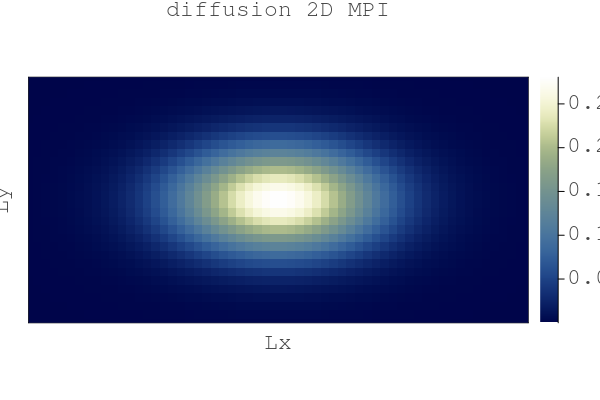

In [13]:
# solution
# Visualisation script for the 2D MPI solver
using Plots, MAT

nprocs = (2, 1) # nprocs (x, y) dim

@views function vizme2D_mpi(nprocs)
    H  = []
    ip = 1
    for ipx = 1:nprocs[1]
        for ipy = 1:nprocs[2]
            file = matopen("H_$(ip-1).mat"); H_loc = read(file, "H"); close(file)
            nx_i, ny_i = size(H_loc,1)-2, size(H_loc,2)-2
            ix1, iy1   = 1+(ipx-1)*nx_i, 1+(ipy-1)*ny_i
            if (ip==1)  H = zeros(nprocs[1]*nx_i, nprocs[2]*ny_i)  end
            H[ix1:ix1+nx_i-1,iy1:iy1+ny_i-1] .= H_loc[2:end-1,2:end-1]
            ip += 1
        end
    end
    fontsize = 12
    opts = (aspect_ratio=1, yaxis=font(fontsize, "Courier"), xaxis=font(fontsize, "Courier"),
        ticks=nothing, framestyle=:box, titlefontsize=fontsize, titlefont="Courier",
        xlabel="Lx", ylabel="Ly", xlims=(1, size(H,1)), ylims=(1, size(H,2)) )
    display(heatmap(H'; c=:davos, title="diffusion 2D MPI", opts...))
    return
end

vizme2D_mpi(nprocs)

A further step would be to use CUDA-aware MPI, which allows to avoid these explicit copies from host to device. It permits to pass directly GPU memory pointers to the MPI functions. CUDA-aware MPI enables to leverage Remote Direct Memory Access (RDMA) which can be of great benefit in many HPC scenarios.

This completes the introduction to distributed parallelization with Julia. Note that the highlevel Julia HPC package [ImplicitGlobalGrid.jl](https://github.com/eth-cscs/ImplicitGlobalGrid.jl) renders the distributed parallelization of stencil codes with GPU and CPU an almost trivial task and enables close to ideal weak scaling of real-world applications on thousands of GPUs. As little as three functions can be enough to transform a single GPU/CPU application into a massively scaling Multi-GPU/CPU application (see for example [here](https://github.com/eth-cscs/ImplicitGlobalGrid.jl/blob/master/examples/diffusion3D_multigpu_CuArrays_novis.jl)). The documentation of  [ImplicitGlobalGrid.jl](https://github.com/eth-cscs/ImplicitGlobalGrid.jl) provides more information.